<a href="https://colab.research.google.com/github/dTenebrae/nlp/blob/main/lesson4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Тематическое моделирование 



**Задание 1**  
Взять ноутбук с вебинара изменить тематики (минимум 3-ри тематики взять) построить тематическую модель, попробовать проинтерпретировать полученные тематики. Насколько они похожи на то что вы выделяли из корпуса. Возможно большее количество тематик так же хорошо интерпретируется проверьте это. Подберите оптимальное количество тематик с точки зрения интерпретации результатов. Не забывайте чтобы получить хорошие тематики надо хорошо почистить тексты.

Построим тематические модели для корпуса новостей Lenta.ru, с которым мы уже работали ранее.

In [247]:
from IPython.display import clear_output

In [248]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz
clear_output()

In [249]:
!pip install pyLDAvis
clear_output()

In [250]:
# import os
# os.kill(os.getpid(), 9)

In [251]:
from IPython.display import clear_output
!pip install corus
!pip install pymorphy2
!pip install -U gensim
clear_output()

In [252]:
import pandas as pd

import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
# from pymystem3 import Mystem

import pymorphy2

from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import nltk
nltk.download('stopwords')
clear_output()

In [253]:
from corus import load_lenta

path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [254]:
%%time
data = [(record.title, record.topic, record.text, record.tags) for record in records]

CPU times: user 38.2 s, sys: 2.7 s, total: 40.9 s
Wall time: 40.9 s


In [255]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [256]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])

In [257]:
data.sample(3)

,title,topic,text,tags
233840,Госдума уберет требования к Visa и MasterCard из закона,Экономика,"Российские законодатели намерены вывести требования к Visa и MasterCard из закона о национальной платежной системе. Об этом сообщает РИА Новости, ссылаясь на источник, знакомый с текстом поправок. Право устанавливать взносы и штрафы для данных компаний будет передано либо ЦБ, либо правительству. Отмечается, что международные платежные системы резко отреагировали на закон. В частности, совет директоров Visa решил, что компания не будет платить ни копейки, какой бы ни был взнос. 20 мая премьер-министр России Дмитрий Медведев заявил, что Visa и MasterCard обсуждают с ЦБ РФ и коммерческими банками поправки в закон о национальной платежной системе. Оба оператора считают, что эти поправки создают определенные риски для работы в России. Первоначальная версия закона о национальной платежной системе обязывал Visa и MasterCard ежеквартально вносить обеспечительные взносы в размере 25 процентов от среднего дневного объема платежей в России. В компаниях заявляли, что такие страховые депозиты в несколько раз превысят годовой доход компаний в РФ. По некоторым подсчетам, финансовые потери в случае ухода обеих систем из России могут оказаться меньше, чем в случае работы по новым правилам. К примеру, MasterCard, решив сохранить свой бизнес, мог бы лишиться 1,9 миллиарда долларов. Прекращение работы в РФ обошелся бы компании лишь в 350-470 миллионов. Закон о национальной платежной системе был принят после того, как иностранные платежные операторы начали блокировать карты, выпущенные попавшими под санкции российскими банками. В России сочли, что Visa и MasterCard слишком уязвимы для политического давления со стороны правительств стран Запада.",Деньги
676864,Венесуэла возобновила экспорт своей нефти,Экономика,"Венесуэле удалось возобновить экспортные поставки нефти - прозвучало в четверг на внеочередной 122-й конференции Организации стран-экспортеров нефти (ОПЕК) в Вене со ссылкой на заявление министра энергетики и добывающей промышленности Венесуэлы Рафаэля Рамиреса, сообщают РИА ""Новости"". Сам министр из за продолжающейся из-за забастовки не смог приехать на саммит и остался в Каракасе. Из-за всеобщей забастовки, начавшейся 2 декабря, производство нефти в стране сократилось примерно в три раза. Сейчас оно составляет не более 1 миллиона баррелей в сутки по сравнению с 3,1 миллиона, добывавшимися в ноябре. Почти полностью парализована добыча в крупнейшем нефтедобывающем районе страны - Маракайбо, где до забастовки производилось 1,4 миллионов баррелей нефти-сырца в сутки. К акции протеста присоединились практически все нефтеперерабатывающие заводы Венесуэлы и экипажи большинства морских танкеров. По словам Рамиреса, в Карибское море вышел танкер ""Маршал Чуйков"", который с 350 тысячами баррелей нефти взял курс в направлении США, вторым стал танкер ""Айова Спирит"", нефтяной груз которого составляет 450 тысяч баррелей. Уже в ближайшее время из венесуэльских грузовых портов отойдут еще 5 танкеров, которые доставят в США 2 миллиона 230 тысяч баррелей нефти-сырца. Рафаэль Рамирес отметил, что Венесуэла получила поддержку от нефтепроизводителей в странах Латинской Америки, а также от своих коллег по ОПЕК. По мнению венесуэльского министра, нормальные экспортные нефтяные поставки возобновятся уже в ближайшее время, и Венесуэла постарается ""наверстать упущенные из-за забастовки доходы от нефтяного бизнеса"". Венесуэла, единственная латиноамериканская страна, входящая в нефтяной картель, занимает пятое место в мире по экспорту ""черного золота"" и является третьим производителем нефти в ОПЕК после Саудовской Аравии и Ирана с квотой на добычу равной 2,497 тысяч баррелей в сутки. Половина всей добываемой страной нефти идет на экспорт в США. Доходы от нефти обеспечивают половину всех госрасходов и более трети ВВП Венесуэлы.",Все
5916,Ким Кардашьян нарядила сына в водолазку с надписью на русском языке,Ценности,"Участница реалити-шоу «Семейство Кардашьян» Ким К

In [258]:
data['topic'].unique()

array(['Спорт', 'Путешествия', 'Мир', 'Бывший СССР', 'Интернет и СМИ',
       'Силовые структуры', 'Россия', 'Экономика', 'Культура', 'Дом',
       'Наука и техника', 'Из жизни', 'Ценности', 'Бизнес',
       '69-я параллель', '', 'Культпросвет ', 'Крым', 'Оружие', 'Легпром',
       'МедНовости', 'Библиотека', 'ЧМ-2014', 'Сочи'], dtype=object)

In [259]:
len(data)

739350

In [260]:
data.topic.value_counts().head(15)

Россия               160518
Мир                  136680
Экономика            79538 
Спорт                64421 
Культура             53803 
Бывший СССР          53402 
Наука и техника      53136 
Интернет и СМИ       44675 
Из жизни             27611 
Дом                  21734 
Силовые структуры    19596 
Ценности             7766  
Бизнес               7399  
Путешествия          6408  
69-я параллель       1268  
Name: topic, dtype: int64

Для ускорения вычислений оставим тексты из 5 тем:

In [261]:
topics = ['Интернет и СМИ ', 'Бизнес', 'Россия', 'Силовые структуры ', 'Экономика', 
          'Спорт', 'Культура', 'Путешествия', 'Наука и техника']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)
len(data)

425223

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [262]:
morph = pymorphy2.MorphAnalyzer()

In [263]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [264]:
add_stop_list = ["год", "это", "сообщать", "который", "произойти", "находиться", "свой", "также", 
                 "стать", "мочь", "весь", "около", "the", "неколько", "являться", "всё", "время", 
                 "отметить", "заявить", "слово", "ещё", "обнаружить", "новый", "однако", "составить", 
                 "человек", "самый", "получить", "сказать", "считать", "час", "писать", "смочь", 
                 "сделать", "оказаться", "выйти", "пока", "поступить", "составлять", "работать", 
                 "вид", "установить", "оказаться", "позволять", "увеличить", "использовать", "появиться",
                 "очень", "имя", "часть", "против", "занимать", "попасть", "добавить", "рассказать",
                 "выпустить", "написать"]
stopwords_list.extend(add_stop_list)

In [265]:
data.text.iloc[1]

'Сотрудники социальной сети Instagram проанализировали поставленные пользователями смайлики, геолокации и хештеги и опубликовали итоги 2018 года. Об этом сообщается на официальном сайте Instagram. Таким образом, самой счастливой геолокацией Instagram признал Диснейленд в Токио, так как больше всего счастливых смайликов в 2018 году пользователи ставили именно под фотографиями из японского Диснейленда. Также эксперты назвали самый популярный фильтр для лица: им стал фильтр с сердечками на глазах. А, например, самыми часто используемыми хештегами в 2018 году были #metoo, #timesup и #marchforourlives. В ноябре сотрудники британской ассоциации потребителей Which? составили рейтинг самых безопасных стран для путешествий. Специалисты проанализировали 20 самых популярных туристических направлений по четырем критериям: уровень преступности, угроза здоровью, вероятность теракта и стихийных бедствий. Самой безопасной страной по всем параметрам стала Исландия.'

In [266]:
preprocess(data.text.iloc[1])

['сотрудник',
 'социальный',
 'сеть',
 'instagram',
 'проанализировать',
 'поставить',
 'пользователь',
 'смайлик',
 'геолокация',
 'хештег',
 'опубликовать',
 'итог',
 'сообщаться',
 'официальный',
 'сайт',
 'instagram',
 'образ',
 'счастливый',
 'геолокация',
 'instagram',
 'признать',
 'диснейленд',
 'токио',
 'большой',
 'счастливый',
 'смайлик',
 'пользователь',
 'ставить',
 'именно',
 'фотография',
 'японский',
 'диснейленд',
 'эксперт',
 'назвать',
 'популярный',
 'фильтр',
 'лицо',
 'фильтр',
 'сердечко',
 'глаз',
 'например',
 'часто',
 'хештег',
 'metoo',
 'timesup',
 'marchforourlives',
 'ноябрь',
 'сотрудник',
 'британский',
 'ассоциация',
 'потребитель',
 'which',
 'рейтинг',
 'безопасный',
 'страна',
 'путешествие',
 'специалист',
 'проанализировать',
 'популярный',
 'туристический',
 'направление',
 'четыре',
 'критерий',
 'уровень',
 'преступность',
 'угроза',
 'здоровье',
 'вероятность',
 'теракт',
 'стихийный',
 'бедствие',
 'безопасный',
 'страна',
 'параметр',
 'исл

Ниже мы оставим только случайные 10,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [267]:
data = data.sample(30000)
data.topic.value_counts()

Россия             11328
Экономика          5630 
Спорт              4507 
Культура           3820 
Наука и техника    3727 
Бизнес             523  
Путешествия        465  
Name: topic, dtype: int64

In [268]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [269]:
data['text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags
132384,В Госдуме отвергли идею «сажать под колпак» россиян ради контроля их расходов,Экономика,"[первый, замглавы, комитет, госдума, экономический, политика, михаил, емельянов, справедливый, россия, раскритиковать, предложение, минфин, федеральный, налоговый, служба, фнс, контролировать, крупный, расход, гражданин, страна, среда, июль, риа, новость, думать, контрольный, функция, увлекаться, стоить, емельянов, говорить, борьба, коррупция, незаконный, доход, таки, акцент, должный, выявление, преступный, схема, тотальный, контроль, качество, альтернатива, предложить, усилить, мера, финансовый, регулирование, конкретный, преступный, схема, бороться, гражданин, сажать, колпак, резюмировать, парламентарий, минфин, фнс, обсуждать, вопрос, контроль, крупный, расход, население, известно, ранее, июль, отмечаться, ведомство, вернуться, тема, необходимость, наполнять, бюджет, контроль, крупный, расход, доход, физический, лицо, вводиться, гражданин, обязать, отчитываться, покупка, недвижимость, машина, акция, доля, уставный, капиталь, золото, слиток, закон, отменить, ...]",Госэкономика
218209,Путин нарисовал газовый вопрос для Меркель,Россия,"[президент, владимир, путин, помощь, ручка, бумага, постараться, донести, канцлер, фрг, ангел, меркель, российский, позиция, газовый, спор, украина, сообщить, пресс, секретарь, глава, государство, дмитрий, песок, передавать, риа, новость, вчера, путин, достаточно, подробно, меркель, газовый, дело, буквально, взять, ручка, цифра, рисовать, бумага, объяснять, песок, уточнить, отреагировать, меркель, пресс, секретарь, цитировать, тасс, президент, глава, минэнерго, александр, новак, руководитель, газпром, алексей, миллер, продолжить, обсуждение, газовый, проблема, встреча, рамка, саммит, форум, азия, европа, асем, милан, естественно, европейский, партнёр, вести, активизировать, конец, сегодняшний, день, контакт, газовый, тематика, президент, россия, четверг, октябрь, провести, переговоры, канцлер, германия, встреча, продолжаться, сторона, обсудить, урегулирование, кризис, юго, восток, украина, реализация, минский, ...]",Политика
35182,Apple представит свой самый большой iPhone,Наука и техника,"[компания, apple, смартфон, число, большой, iphone, bloomberg, ссылка, источник, данные, агентство, среди, новинка, обновить, версия, iphone, менее, дорогой, модель, флагман, некоторый, ключевой, функция, компания, хотеть, угодить, потребитель, ждать, смартфон, многозадачность, искать, доступный, версия, iphone, смартфон, иметь, экран, разрешение, технология, oled, сканер, face, ожидаться, большой, обновить, смартфон, использоваться, процессор, представить, золото, цвет, некоторый, регион, рассматриваться, возможность, выбор, телефон, sim, карта, бюджетный, версия, экран, edge, edge, сканер, face, удешевить, модель, ожидаться, lcd, экран, алюминиевый, край, чёрный, стекло, задний, панель, презентация, смартфон, традиционно, пройти, осень, источник, агентство, отмечать, план, компания, измениться, пресс, служба, apple, комментарий, отказаться]",Гаджеты


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [270]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [271]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [272]:
%time 
lda = ldamodel.LdaModel(corpus, 
                        id2word=dictionary, 
                        num_topics=len(topics), 
                        chunksize=50, 
                        update_every=1, 
                        passes=2)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [273]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [274]:
print(lda.log_perplexity(corpus))

-8.333715565457101


In [275]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.00024027800117740314


In [276]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.5198680475866024


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [277]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())


  0%|          | 0/5 [00:00<?, ?it/s]

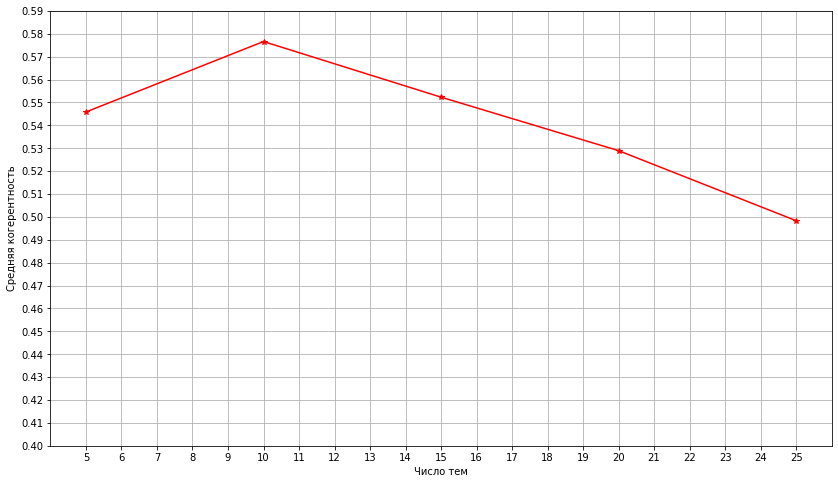

In [278]:
plt.figure(figsize=(14,8))

plt.plot(topics_list, coherences, marker="*", color='red')
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")

plt.xticks(range(5, 26))
plt.yticks(np.arange(0.4, 0.6, 0.01))
plt.grid()
plt.show()

Посмотрим на получившиеся темы:

In [279]:
themes = lda.show_topics(num_topics=(len(topics)), num_words=10, formatted=True)

In [280]:
for i, theme in enumerate(themes):
    print(50 * "=")
    print(f"Theme {i + 1}:")
    for word in theme[1].split("+"):
        print(word.split("*")[1])

Theme 1:
"житель" 
"местный" 
"город" 
"жить" 
"продукт" 
"личный" 
"работник" 
"становиться" 
"посольство" 
"нужный"
Theme 2:
"фильм" 
"картина" 
"британский" 
"роль" 
"режиссёр" 
"женщина" 
"актёр" 
"нью" 
"американский" 
"прокат"
Theme 3:
"партия" 
"заявление" 
"выборы" 
"решение" 
"представитель" 
"отношение" 
"поздний" 
"информация" 
"лидер" 
"власть"
Theme 4:
"банк" 
"правительство" 
"финансовый" 
"развитие" 
"премьер" 
"бюджет" 
"средство" 
"экономический" 
"организация" 
"система"
Theme 5:
"здание" 
"дом" 
"москва" 
"ребёнок" 
"петербург" 
"московский" 
"санкт" 
"центр" 
"новость" 
"город"
Theme 6:
"вырасти" 
"результат" 
"случай" 
"газета" 
"данные" 
"говорить" 
"работа" 
"размер" 
"мнение" 
"дать"
Theme 7:
"самолёт" 
"прокуратура" 
"производство" 
"полёт" 
"обвинять" 
"корпорация" 
"пассажир" 
"авиакомпания" 
"арестовать" 
"аэропорт"
Theme 8:
"россия" 
"президент" 
"российский" 
"владимир" 
"глава" 
"путин" 
"совет" 
"министр" 
"новость" 
"риа"
Theme 9:
"область" 
"управление

In [281]:
topics

['Интернет и СМИ ',
 'Бизнес',
 'Россия',
 'Силовые структуры ',
 'Экономика',
 'Спорт',
 'Культура',
 'Путешествия',
 'Наука и техника']

In [ ]:
Можно увидеть, что разбиение на тематики получилось достаточно качественным, явно можно определить тему бизнеса, России, Культуры, Экономики
